# Editing trees
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/yggdrasil-decision-forests/blob/main/documentation/public/docs/tutorial/editing_trees.ipynb)


## Setup

In [ ]:
pip install ydf -U

In [1]:
import ydf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## What does it mean to edit trees?

In the [inspecting tree notebook](../inspecting_trees), you learned how to access the tree structure. In this notebook, we show how to modify the tree structure of an already trained model and create a new tree manually.

## Dataset

To make the example easier to follow, we use a synthetic dataset following a grid in two dimensions.

In [2]:
def build_grid_dataset(resolution = 20):
    """Creates a 2d grid."""
    vs = np.linspace(0, 1, resolution)
    xs, ys = np.meshgrid(vs, vs)
    return pd.DataFrame({
        "x": xs.flatten(), 
        "y": ys.flatten()
    })

dataset = build_grid_dataset()
dataset

,x,y
0,0.000000,0.0
1,0.052632,0.0
2,0.105263,0.0
3,0.157895,0.0
4,0.210526,0.0
...,...,...
395,0.789474,1.0
396,0.842105,1.0
397,0.894737,1.0
398,0.947368,1.0


The `plot_predictions` method plots predictions on the 2D grid defined by `build_grid_dataset`.

Let's define and plot a syncthetic label `x>=0.5 and y>=0.5`.

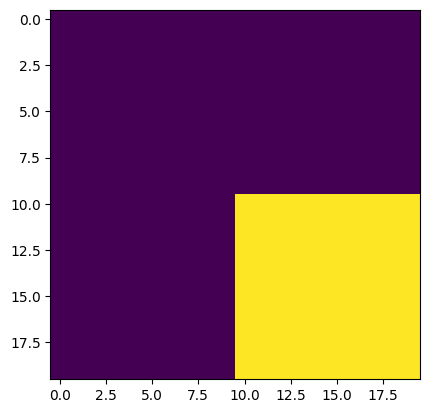

In [7]:
def plot_predictions(values, resolution = 20):
    plt.imshow(np.reshape(values,[resolution,resolution]), interpolation="none")

dataset["label"] = (dataset.x >= 0.5) & (dataset.y >= 0.5)
plot_predictions(dataset["label"])

## Edit an existing model

We train a single tree, then edit its structure and check that its predictions are changed as expected.


In [32]:
model = ydf.CartLearner(label="label", task=ydf.Task.REGRESSION).train(dataset)

Train model on 400 examples
Model trained in 0:00:00.002200


We plot the tree structure of the model. We expect to see a tree equivalent to `x>=0.5 and y>=0.5`.

In [33]:
model.print_tree(0)

'x' >= 0.5 [score=0.066036 missing=True]
    ├─(pos)─ 'y' >= 0.5 [score=0.2498 missing=True]
    │        ├─(pos)─ value=1 sd=0
    │        └─(neg)─ value=0 sd=0
    └─(neg)─ value=0 sd=0


Looks good.

The predictions of the model are similar to the labels.

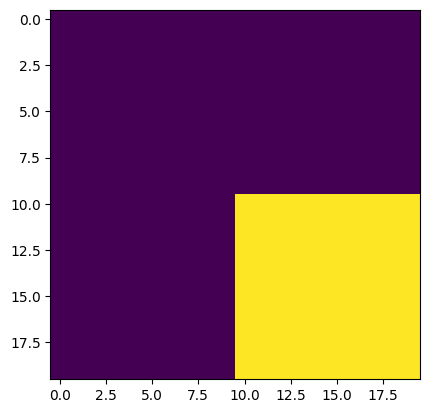

In [36]:
plot_predictions(model.predict(dataset))

Let's change the threshold value on the first condition. We replace x >= 0.5 with x >= 0.8.

In [40]:
# Extract the tree
tree = model.get_tree(0)
tree

Tree(root=NonLeaf(value=RegressionValue(num_examples=361.0, value=0.2548476457595825, standard_deviation=0.4357755420494278), condition=NumericalHigherThanCondition(missing=True, score=0.06603582203388214, attribute=1, threshold=0.5), pos_child=NonLeaf(value=RegressionValue(num_examples=179.0, value=0.5139665007591248, standard_deviation=0.49980489935966577), condition=NumericalHigherThanCondition(missing=True, score=0.24980494379997253, attribute=2, threshold=0.5), pos_child=Leaf(value=RegressionValue(num_examples=92.0, value=1.0, standard_deviation=0.0)), neg_child=Leaf(value=RegressionValue(num_examples=87.0, value=0.0, standard_deviation=0.0))), neg_child=Leaf(value=RegressionValue(num_examples=182.0, value=0.0, standard_deviation=0.0))))

In [41]:
# Change the tree
tree.root.condition.threshold = 0.8

In [42]:
# Update the model
model.set_tree(0, tree)

Let's check that the model was changed: 

In [43]:
model.print_tree(0)

'x' >= 0.8 [score=0.066036 missing=True]
    ├─(pos)─ 'y' >= 0.5 [score=0.2498 missing=True]
    │        ├─(pos)─ value=1 sd=0
    │        └─(neg)─ value=0 sd=0
    └─(neg)─ value=0 sd=0


Finally, let's check the new predictions:

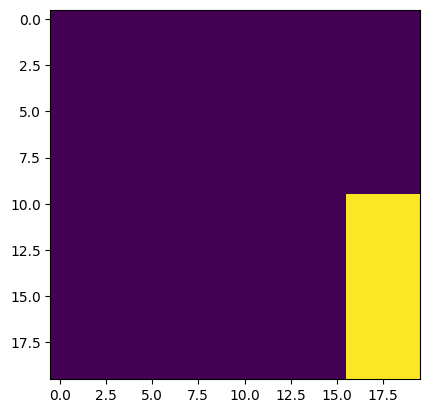

In [44]:
plot_predictions(model.predict(dataset))

## Create a model

YDF also supports the creation of new trees. To do this, we will define a model with zero trees and then add a tree manually.

In [58]:
model = ydf.RandomForestLearner(label="label", num_trees=0, task=ydf.Task.REGRESSION).train(dataset)

Train model on 400 examples
Model trained in 0:00:00.003442


As expected, the model does not contain any trees.

In [59]:
model.num_trees()

0

Let's add a new tree.

In a tree, the input features are indexed by integers called the "column index". The `model.input_features()` list the available input features and the corresponding column index.

In [60]:
model.input_features()

[InputFeature(name='x', semantic=<Semantic.NUMERICAL: 1>, column_idx=1),
 InputFeature(name='y', semantic=<Semantic.NUMERICAL: 1>, column_idx=2)]

The column index of the feature "x" is 1. We define a tree with a single condition testing `x >= 0.6`.

In [61]:
tree = ydf.tree.Tree(
    root=ydf.tree.NonLeaf(
        condition=ydf.tree.NumericalHigherThanCondition(attribute=1, # Feature "x"
                                                        threshold=0.6,
                                                        missing=False, # Value of the condition when the feature is missing. Not used here.
                                                        score=1, # How good is the condition. Not used here.
                                              ),
        pos_child=ydf.tree.Leaf(value=ydf.tree.RegressionValue(num_examples=1.0, value=1.0)),
        neg_child=ydf.tree.Leaf(value=ydf.tree.RegressionValue(num_examples=1.0, value=0.0)),
    )
)

We plot the newly created tree.

**Note:** The *dataspec* of the model (available with `model.data_spec()`) defines the columns (e.g. input features, label, weights) expected by the model. It also defines the name of the column and their dictionary (in the case of text categorical features).

In [62]:
print(tree.pretty(model.data_spec()))

'x' >= 0.6 [score=1 missing=False]
    ├─(pos)─ value=1
    └─(neg)─ value=0



The tree is added to the model:

In [63]:
model.add_tree(tree)

Finally, we plot the model predictions.

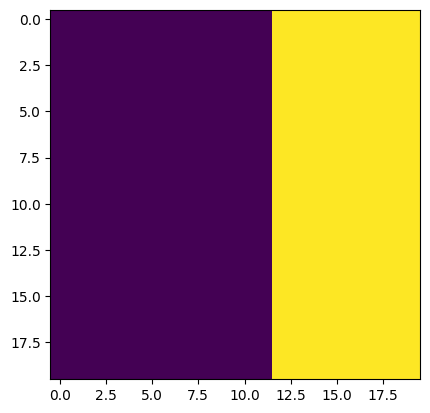

In [64]:
plot_predictions(model.predict(dataset))